# Neural Network Preprocessing

This notebook prepares the engineered dataset for neural network modeling.

## Steps:
1. Load engineered features
2. Encode categorical features
3. Scale numeric features
4. Create time-aware train/validation/test splits
5. Create sequence data for RNN/LSTM
6. Save processed datasets

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import warnings

# Configure
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
# Load the engineered dataset
df = pd.read_csv('../data/clean/fertility_rate_engineered_features.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: (13205, 24)

Columns: ['Country Name', 'Country Code', 'Year', 'Maternal mortality ratio (per 100,000 live births)', 'Fertility rate', 'Urban population over total population', 'Capital GDP in USD', 'InfantMortality', 'LifeExpectancy', 'InfantMortality_lag3', 'LifeExpectancy_lag3', 'Urban population over total population_lag3', 'Maternal mortality ratio (per 100,000 live births)_lag3', 'Capital GDP in USD_lag3', 'InfantMortality_pct_change', 'LifeExpectancy_pct_change', 'Urban population over total population_pct_change', 'Maternal mortality ratio (per 100,000 live births)_pct_change', 'Capital GDP in USD_pct_change', 'HealthcareQuality_Index', 'Urban_GDP_Interaction', 'Decade', 'Era', 'Development_Level']

First few rows:


,Country Name,Country Code,Year,"Maternal mortality ratio (per 100,000 live births)",Fertility rate,Urban population over total population,Capital GDP in USD,InfantMortality,LifeExpectancy,InfantMortality_lag3,LifeExpectancy_lag3,Urban population over total population_lag3,"Maternal mortality ratio (per 100,000 live births)_lag3",Capital GDP in USD_lag3,InfantMortality_pct_change,LifeExpectancy_pct_change,Urban population over total population_pct_change,"Maternal mortality ratio (per 100,000 live births)_pct_change",Capital GDP in USD_pct_change,HealthcareQuality_Index,Urban_GDP_Interaction,Decade,Era,Development_Level
0,Afghanistan,AFG,1963.000,2440.545,7.302,9.276,156.233,242.500,34.201,251.200,32.799,8.401,1839.168,156.574,-1.182,1.315,3.342,11.230,-0.082,0.120,46.915,1960,1960-1979,Low Income
1,Afghanistan,AFG,1964.000,2716.075,7.304,9.586,156.120,239.700,34.673,248.400,33.291,8.684,1989.743,156.481,-1.155,1.380,3.342,11.290,-0.073,0.129,48.476,1960,1960-1979,Low Income
2,Afghanistan,AFG,1965.000,2966.901,7.305,9.904,156.078,236.900,35.124,245.400,33.757,8.976,2194.152,156.361,-1.168,1.301,3.317,9.235,-0.026,0.138,50.082,1960,1960-1979,Low Income
3,Afghanistan,AFG,1966.000,3032.996,7.320,10.233,156.112,234.200,35.583,242.500,34.201,9.276,2440.545,156.233,-1.140,1.307,3.322,2.228,0.022,0.147,51.748,1960,1960-1979,Low Income
4,Afghanistan,AFG,1967.000,2819.647,7.339,10.570,156.194,231.400,36.042,239.700,34.673,9.586,2716.075,156.120,-1.196,1.290,3.293,-7.034,0.052,0.156,53.458,1960,1960-1979,Low Income


In [3]:
# Check data types and missing values
print("Data Info:")
print("="*80)
df.info()
print(f"\nMissing values: {df.isnull().sum().sum()}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13205 entries, 0 to 13204
Data columns (total 24 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Country Name                                                   13205 non-null  object 
 1   Country Code                                                   13205 non-null  object 
 2   Year                                                           13205 non-null  float64
 3   Maternal mortality ratio (per 100,000 live births)             13205 non-null  float64
 4   Fertility rate                                                 13205 non-null  float64
 5   Urban population over total population                         13205 non-null  float64
 6   Capital GDP in USD                                             13205 non-null  float64
 7   InfantMortality                                

## 2. Separate Features by Type

In [4]:
# Define feature categories
identifier_cols = ['Country Name', 'Country Code', 'Year']
target_col = 'Fertility rate'
categorical_cols = ['Era', 'Development_Level', 'Decade']

# Numeric features are everything else
numeric_cols = [col for col in df.columns if col not in identifier_cols + [target_col] + categorical_cols]

print(f"Identifier columns ({len(identifier_cols)}): {identifier_cols}")
print(f"\nTarget column: {target_col}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumeric feature columns ({len(numeric_cols)}):")
for col in numeric_cols:
    print(f"  - {col}")

Identifier columns (3): ['Country Name', 'Country Code', 'Year']

Target column: Fertility rate

Categorical columns (3): ['Era', 'Development_Level', 'Decade']

Numeric feature columns (17):
  - Maternal mortality ratio (per 100,000 live births)
  - Urban population over total population
  - Capital GDP in USD
  - InfantMortality
  - LifeExpectancy
  - InfantMortality_lag3
  - LifeExpectancy_lag3
  - Urban population over total population_lag3
  - Maternal mortality ratio (per 100,000 live births)_lag3
  - Capital GDP in USD_lag3
  - InfantMortality_pct_change
  - LifeExpectancy_pct_change
  - Urban population over total population_pct_change
  - Maternal mortality ratio (per 100,000 live births)_pct_change
  - Capital GDP in USD_pct_change
  - HealthcareQuality_Index
  - Urban_GDP_Interaction


## 3. Encode Categorical Features

In [5]:
# Create a copy of the dataframe for processing
df_processed = df.copy()

# One-hot encode categorical features
print("Encoding categorical features...\n")

# Store original categorical values for reference
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

# One-hot encode (drop_first=True to avoid multicollinearity)
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True, dtype=int)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"New columns added: {df_encoded.shape[1] - df_processed.shape[1]}")

Encoding categorical features...

Era: ['1960-1979' '1980-1999' '2000-2019' '2020+']
Development_Level: ['Low Income' 'Lower Middle Income' 'Upper Middle Income' 'High Income']
Decade: [1960 1970 1980 1990 2000 2010 2020]

Shape after encoding: (13205, 33)
New columns added: 9


## 4. Visualize Feature Distributions Before Scaling

In [6]:
# Check distributions and scales of numeric features
print("Numeric Feature Statistics (before scaling):")
print("="*80)
df[numeric_cols].describe().T[['mean', 'std', 'min', 'max']]

Numeric Feature Statistics (before scaling):


,mean,std,min,max
"Maternal mortality ratio (per 100,000 live births)",326.522,537.693,1.000,8045.000
Urban population over total population,52.585,25.599,2.193,100.000
Capital GDP in USD,9118.646,18053.206,11.801,256580.515
InfantMortality,46.884,42.734,1.400,245.500
LifeExpectancy,65.873,10.662,20.721,86.372
InfantMortality_lag3,50.385,44.759,1.500,251.200
LifeExpectancy_lag3,65.062,10.922,20.721,86.151
Urban population over total population_lag3,51.393,25.733,2.077,100.000
"Maternal mortality ratio (per 100,000 live births)_lag3",357.824,572.217,1.000,8045.000
Capital GDP in USD_lag3,8172.894,16572.011,11.801,204263.797


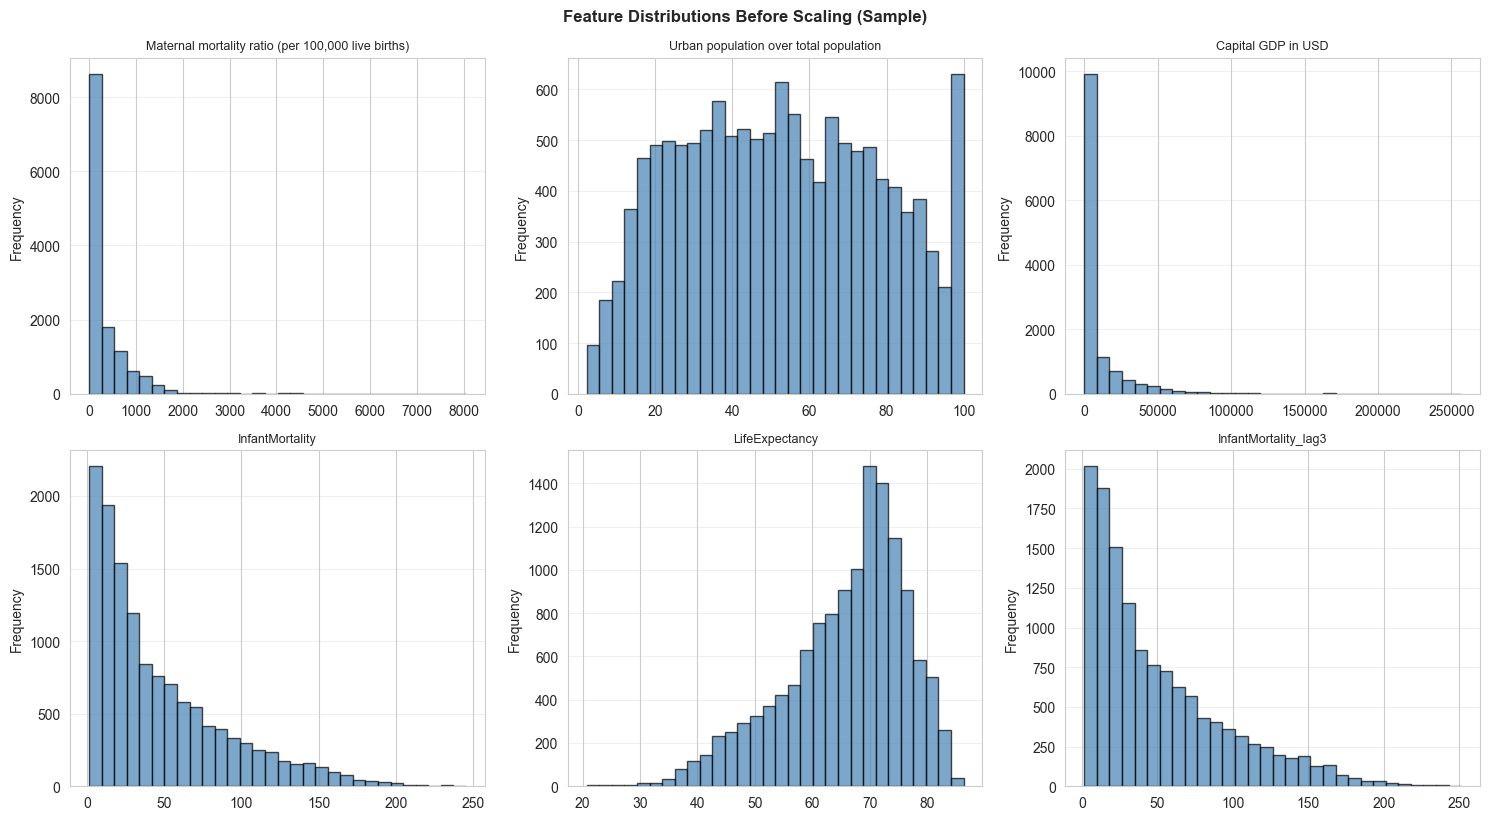

In [19]:
# Visualize feature scales (sample of features)
sample_features = numeric_cols[:6]  # First 6 numeric features

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(sample_features):
    axes[idx].hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=9)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Feature Distributions Before Scaling (Sample)', y=1.02, fontsize=12, fontweight='bold')
plt.show()

## 5. Create Time-Aware Train/Validation/Test Split

We'll use:
- **Train**: 1963-2010 (70% of data)
- **Validation**: 2011-2017 (15% of data)
- **Test**: 2018-2023 (15% of data)

This ensures we train on the past and test on the future.

In [8]:
# Define split years
train_end_year = 2010
val_end_year = 2017

# Create splits based on year
train_mask = df_encoded['Year'] <= train_end_year
val_mask = (df_encoded['Year'] > train_end_year) & (df_encoded['Year'] <= val_end_year)
test_mask = df_encoded['Year'] > val_end_year

# Split the data
train_df = df_encoded[train_mask].copy()
val_df = df_encoded[val_mask].copy()
test_df = df_encoded[test_mask].copy()

print("Time-Aware Split Summary:")
print("="*80)
print(f"Train set: {len(train_df):,} samples ({len(train_df)/len(df_encoded)*100:.1f}%) - Years {train_df['Year'].min():.0f} to {train_df['Year'].max():.0f}")
print(f"Val set:   {len(val_df):,} samples ({len(val_df)/len(df_encoded)*100:.1f}%) - Years {val_df['Year'].min():.0f} to {val_df['Year'].max():.0f}")
print(f"Test set:  {len(test_df):,} samples ({len(test_df)/len(df_encoded)*100:.1f}%) - Years {test_df['Year'].min():.0f} to {test_df['Year'].max():.0f}")
print(f"\nTotal: {len(df_encoded):,} samples")

Time-Aware Split Summary:
Train set: 10,384 samples (78.6%) - Years 1963 to 2010
Val set:   1,519 samples (11.5%) - Years 2011 to 2017
Test set:  1,302 samples (9.9%) - Years 2018 to 2023

Total: 13,205 samples


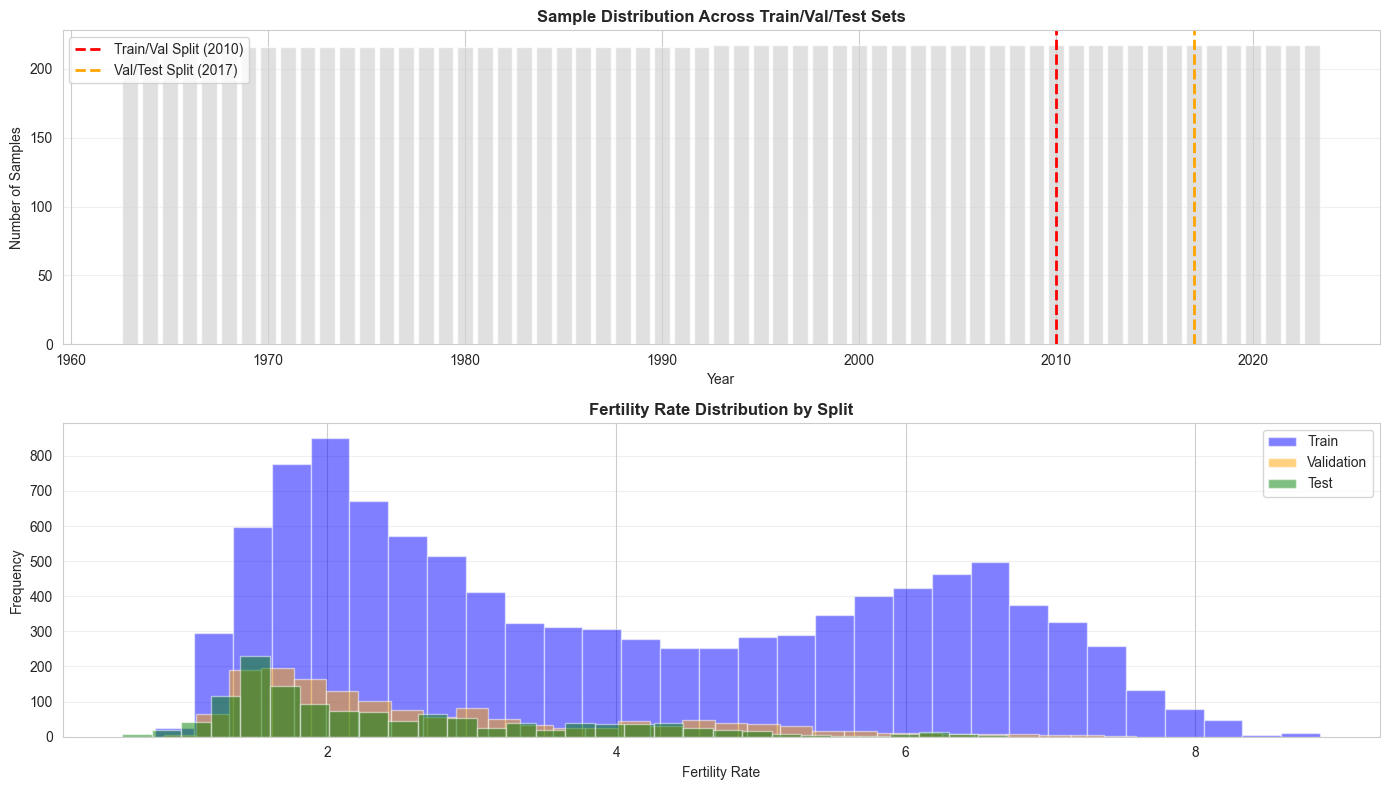

In [9]:
# Visualize the split
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Sample distribution by year
year_counts = df_encoded.groupby('Year').size()
axes[0].bar(year_counts.index, year_counts.values, color='lightgray', alpha=0.7)
axes[0].axvline(x=train_end_year, color='red', linestyle='--', linewidth=2, label=f'Train/Val Split ({train_end_year})')
axes[0].axvline(x=val_end_year, color='orange', linestyle='--', linewidth=2, label=f'Val/Test Split ({val_end_year})')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Sample Distribution Across Train/Val/Test Sets', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Fertility rate distribution by split
train_df['Fertility rate'].hist(bins=30, alpha=0.5, label='Train', ax=axes[1], color='blue')
val_df['Fertility rate'].hist(bins=30, alpha=0.5, label='Validation', ax=axes[1], color='orange')
test_df['Fertility rate'].hist(bins=30, alpha=0.5, label='Test', ax=axes[1], color='green')
axes[1].set_xlabel('Fertility Rate')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Fertility Rate Distribution by Split', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Scale Numeric Features

**IMPORTANT**: We fit the scaler ONLY on training data to prevent data leakage!

In [10]:
# Get all columns that need scaling (numeric features only)
# We'll keep identifiers (Country Name, Country Code, Year) unscaled for reference
cols_to_scale = numeric_cols.copy()

print(f"Scaling {len(cols_to_scale)} numeric features...")
print(f"\nFeatures to scale:")
for col in cols_to_scale:
    print(f"  - {col}")

# Initialize scaler
scaler = StandardScaler()

# Fit scaler ONLY on training data
scaler.fit(train_df[cols_to_scale])

# Transform all splits using the same scaler
train_df[cols_to_scale] = scaler.transform(train_df[cols_to_scale])
val_df[cols_to_scale] = scaler.transform(val_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

print("\n✓ Scaling complete!")
print("\nScaler fitted on training data and applied to all splits.")

Scaling 17 numeric features...

Features to scale:
  - Maternal mortality ratio (per 100,000 live births)
  - Urban population over total population
  - Capital GDP in USD
  - InfantMortality
  - LifeExpectancy
  - InfantMortality_lag3
  - LifeExpectancy_lag3
  - Urban population over total population_lag3
  - Maternal mortality ratio (per 100,000 live births)_lag3
  - Capital GDP in USD_lag3
  - InfantMortality_pct_change
  - LifeExpectancy_pct_change
  - Urban population over total population_pct_change
  - Maternal mortality ratio (per 100,000 live births)_pct_change
  - Capital GDP in USD_pct_change
  - HealthcareQuality_Index
  - Urban_GDP_Interaction

✓ Scaling complete!

Scaler fitted on training data and applied to all splits.


In [11]:
# Verify scaling worked
print("Scaled Feature Statistics (Training Set):")
print("="*80)
train_df[cols_to_scale].describe().T[['mean', 'std', 'min', 'max']]

Scaled Feature Statistics (Training Set):


,mean,std,min,max
"Maternal mortality ratio (per 100,000 live births)",0.000,1.000,-0.641,13.089
Urban population over total population,-0.000,1.000,-1.885,1.942
Capital GDP in USD,-0.000,1.000,-0.490,14.877
InfantMortality,-0.000,1.000,-1.149,4.294
LifeExpectancy,-0.000,1.000,-4.066,1.914
InfantMortality_lag3,-0.000,1.000,-1.183,4.153
LifeExpectancy_lag3,0.000,1.000,-3.905,1.929
Urban population over total population_lag3,0.000,1.000,-1.832,1.984
"Maternal mortality ratio (per 100,000 live births)_lag3",-0.000,1.000,-0.663,12.269
Capital GDP in USD_lag3,-0.000,1.000,-0.482,15.471


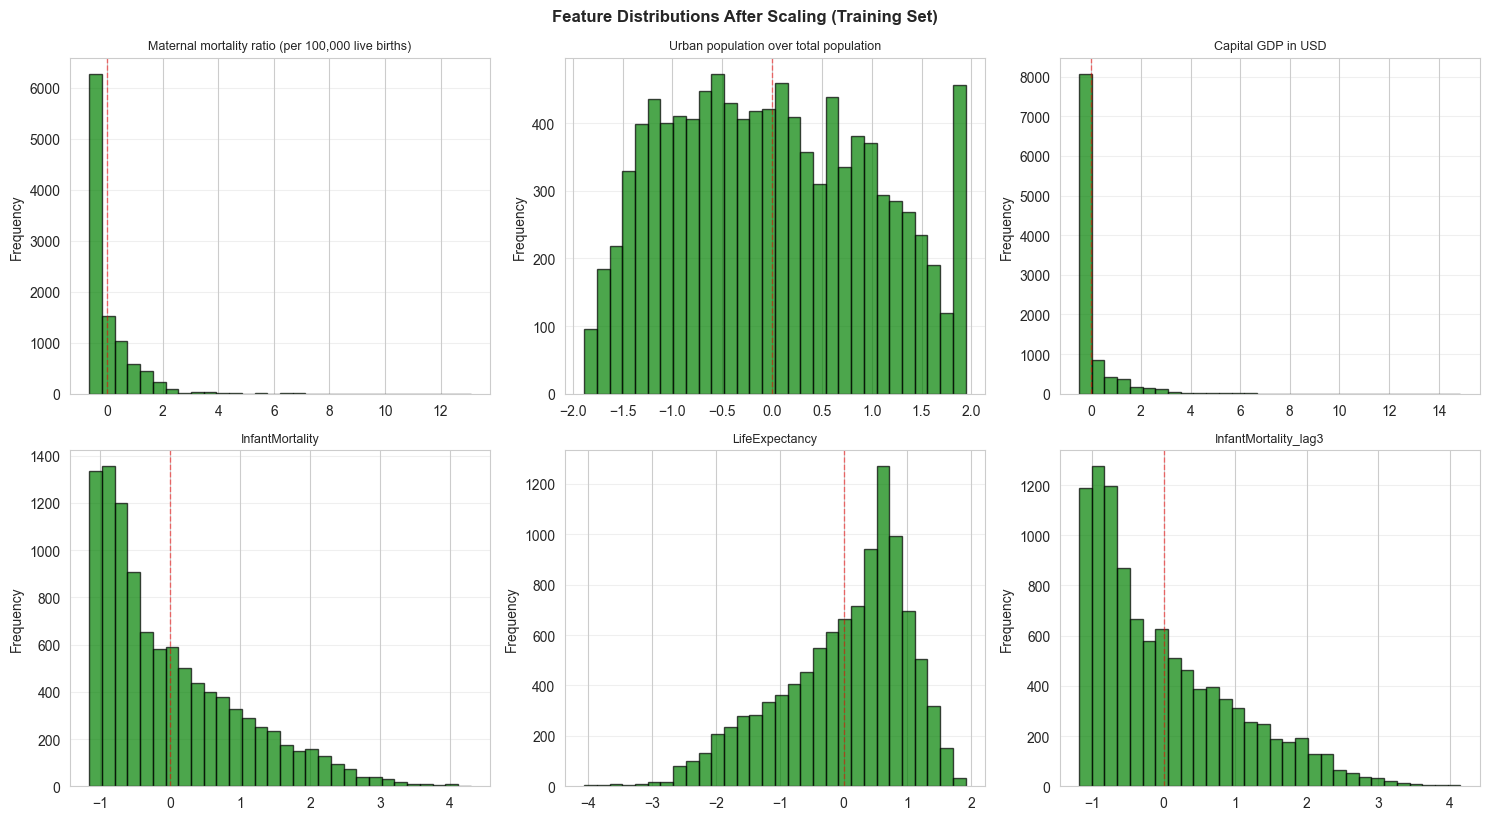

In [20]:
# Visualize scaled features (same sample as before)
sample_features_scaled = [col for col in sample_features if col in cols_to_scale][:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(sample_features_scaled):
    axes[idx].hist(train_df[col].dropna(), bins=30, color='green', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=9)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.suptitle('Feature Distributions After Scaling (Training Set)', y=1.02, fontsize=12, fontweight='bold')
plt.show()

## 7. Prepare Data for Standard Neural Network

For a standard feedforward neural network, we just need X (features) and y (target).

In [13]:
# Separate features and target for standard neural network
# Exclude identifiers from features
feature_cols = [col for col in train_df.columns if col not in identifier_cols + [target_col]]

# Create X and y for each split
X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_val = val_df[feature_cols].values
y_val = val_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

print("Standard Neural Network Data:")
print("="*80)
print(f"X_train shape: {X_train.shape} (samples, features)")
print(f"y_train shape: {y_train.shape}")
print(f"\nX_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nTotal features: {X_train.shape[1]}")

Standard Neural Network Data:
X_train shape: (10384, 29) (samples, features)
y_train shape: (10384,)

X_val shape: (1519, 29)
y_val shape: (1519,)

X_test shape: (1302, 29)
y_test shape: (1302,)

Total features: 29


## 8. Prepare Sequence Data for RNN/LSTM

RNNs and LSTMs need sequences of data. We'll create sequences where:
- **Input**: Last N years of data for a country
- **Output**: Fertility rate for the next year

For example, with sequence_length=5:
- Use data from years [1963, 1964, 1965, 1966, 1967] to predict 1968

In [14]:
def create_sequences(df, sequence_length=5, feature_cols=None, target_col='Fertility rate'):
    """
    Create sequences for RNN/LSTM training.
    
    Parameters:
    - df: DataFrame with data sorted by Country and Year
    - sequence_length: Number of time steps to use as input
    - feature_cols: List of feature column names
    - target_col: Name of target column
    
    Returns:
    - X_sequences: 3D array (samples, sequence_length, features)
    - y_sequences: 1D array (samples,)
    - metadata: DataFrame with country and year info for each sequence
    """
    X_sequences = []
    y_sequences = []
    metadata = []
    
    # Group by country
    for country, country_data in df.groupby('Country Name'):
        # Sort by year within each country
        country_data = country_data.sort_values('Year')
        
        # Create sequences for this country
        for i in range(len(country_data) - sequence_length):
            # Get sequence of features
            sequence = country_data.iloc[i:i+sequence_length][feature_cols].values
            
            # Get target (next year's fertility rate)
            target = country_data.iloc[i+sequence_length][target_col]
            
            X_sequences.append(sequence)
            y_sequences.append(target)
            
            # Store metadata for reference
            metadata.append({
                'Country': country,
                'Last_Year_in_Sequence': country_data.iloc[i+sequence_length-1]['Year'],
                'Target_Year': country_data.iloc[i+sequence_length]['Year']
            })
    
    return np.array(X_sequences), np.array(y_sequences), pd.DataFrame(metadata)

print("Sequence creation function defined!")

Sequence creation function defined!


In [15]:
# Set sequence length
sequence_length = 5  # Use 5 years of history to predict next year

print(f"Creating sequences with sequence_length={sequence_length}...\n")

# Create sequences for each split
X_train_seq, y_train_seq, train_seq_meta = create_sequences(
    train_df, sequence_length=sequence_length, feature_cols=feature_cols, target_col=target_col
)

X_val_seq, y_val_seq, val_seq_meta = create_sequences(
    val_df, sequence_length=sequence_length, feature_cols=feature_cols, target_col=target_col
)

X_test_seq, y_test_seq, test_seq_meta = create_sequences(
    test_df, sequence_length=sequence_length, feature_cols=feature_cols, target_col=target_col
)

print("RNN/LSTM Sequence Data:")
print("="*80)
print(f"X_train_seq shape: {X_train_seq.shape} (samples, sequence_length, features)")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"\nX_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"\nX_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")
print(f"\nSequence length: {sequence_length} time steps")
print(f"Features per time step: {X_train_seq.shape[2]}")

Creating sequences with sequence_length=5...

RNN/LSTM Sequence Data:
X_train_seq shape: (9299, 5, 29) (samples, sequence_length, features)
y_train_seq shape: (9299,)

X_val_seq shape: (434, 5, 29)
y_val_seq shape: (434,)

X_test_seq shape: (217, 5, 29)
y_test_seq shape: (217,)

Sequence length: 5 time steps
Features per time step: 29


## 9. Save Processed Data

We'll save all the processed datasets and the scaler for use in modeling notebooks.

In [17]:
import os

# Create directory for processed data
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

print(f"Saving processed data to {processed_dir}/...\n")

# Save standard neural network data
np.save(f'{processed_dir}/X_train.npy', X_train)
np.save(f'{processed_dir}/y_train.npy', y_train)
np.save(f'{processed_dir}/X_val.npy', X_val)
np.save(f'{processed_dir}/y_val.npy', y_val)
np.save(f'{processed_dir}/X_test.npy', X_test)
np.save(f'{processed_dir}/y_test.npy', y_test)

print("✓ Standard neural network data saved")

# Save RNN/LSTM sequence data
np.save(f'{processed_dir}/X_train_seq.npy', X_train_seq)
np.save(f'{processed_dir}/y_train_seq.npy', y_train_seq)
np.save(f'{processed_dir}/X_val_seq.npy', X_val_seq)
np.save(f'{processed_dir}/y_val_seq.npy', y_val_seq)
np.save(f'{processed_dir}/X_test_seq.npy', X_test_seq)
np.save(f'{processed_dir}/y_test_seq.npy', y_test_seq)

print("✓ RNN/LSTM sequence data saved")

# Save metadata for sequences
train_seq_meta.to_csv(f'{processed_dir}/train_seq_metadata.csv', index=False)
val_seq_meta.to_csv(f'{processed_dir}/val_seq_metadata.csv', index=False)
test_seq_meta.to_csv(f'{processed_dir}/test_seq_metadata.csv', index=False)

print("✓ Sequence metadata saved")

# Save the scaler for future use
with open(f'{processed_dir}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Scaler saved")

# Save feature names for reference
with open(f'{processed_dir}/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

print("✓ Feature names saved")

# Save configuration info
config = {
    'sequence_length': sequence_length,
    'train_years': f"{train_df['Year'].min():.0f}-{train_df['Year'].max():.0f}",
    'val_years': f"{val_df['Year'].min():.0f}-{val_df['Year'].max():.0f}",
    'test_years': f"{test_df['Year'].min():.0f}-{test_df['Year'].max():.0f}",
    'n_features': len(feature_cols),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'train_sequences': len(X_train_seq),
    'val_sequences': len(X_val_seq),
    'test_sequences': len(X_test_seq)
}

import json
with open(f'{processed_dir}/config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✓ Configuration saved")

print("\n" + "="*80)
print("ALL DATA SAVED SUCCESSFULLY!")
print("="*80)

Saving processed data to ../data/processed/...

✓ Standard neural network data saved
✓ RNN/LSTM sequence data saved
✓ Sequence metadata saved
✓ Scaler saved
✓ Feature names saved
✓ Configuration saved

ALL DATA SAVED SUCCESSFULLY!
